# Imports

In [1]:
import pandas as pd
from gensim.corpora import Dictionary
from tqdm import tqdm
import ast
from pattern.text.en import singularize

# Data processing

In [5]:
# how many rows of this huge dataset do we want? None = all of them
rows = None

# read the file in as as pandas DF
data = pd.read_csv('./full_dataset.csv', nrows = rows, usecols=['NER'])

# Convert the list of string representations into a list of lists
tokenized = [ast.literal_eval(elem) for elem in tqdm(data['NER'].tolist())]

# and empty list for receiving the singular version of whatever the ingredient is
singular = []
for row in tqdm(tokenized):
    row_singularized = []
    for elem in row:
        row_singularized.append(singularize(elem))
    singular.append(row_singularized)

# Parse the list of lists into a dictionary and filter it 
dictionary = Dictionary(singular)
dictionary.filter_extremes(no_below=100, no_above=0.30)

# Construct a corpus of texts using the dictionary and the list of ingredients
corpus = [dictionary.doc2bow(doc) for doc in tqdm(singular)]

# Finding the right number of topics

In [11]:
# import the parallel version of the LDA model, and a way to measure its coherence
from gensim.models import LdaMulticore, CoherenceModel

# Set training parameters.
chunksize = 1000
passes = 2
workers = 4
iterations =50
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # initialize the dictionary
id2word = dictionary.id2token

# A list of coherence values, so we can see which one does best
coherences = []

In [ ]:
for num_topics in tqdm(range(3,200, 5)):
    # for every value of K, build a model with the data
    ldamodel = LdaMulticore( 
        corpus=corpus,
        id2word=id2word,
        chunksize=chunksize,
        workers=workers,
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every
    )
    

    # Compute coherence score for that model
    coherence_model_lda = CoherenceModel(model=ldamodel, 
                                         corpus=corpus, 
                                         dictionary=id2word, 
                                         coherence='u_mass')
    coherence_lda = coherence_model_lda.get_coherence()
    
    # Add the coherence to the list for plotting
    coherences.append({"num_topics":num_topics, "coherence":coherence_lda})

<AxesSubplot:xlabel='num_topics'>

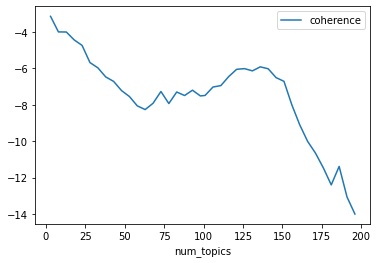

In [36]:
# Plot the curve, and pray for an elbow
pd.DataFrame(coherences).plot(x = "num_topics", y = "coherence")

# Build the final model

In this case, we see that K of approximately 135 seems to be the right place to try. 

In [29]:
ldamodel = LdaMulticore( 
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    workers=workers,
    iterations=iterations,
    num_topics=135,
    passes=passes,
    eval_every=None,
    minimum_probability=0.05
    )

# Look at the topics and their corresponding ingredients: 

In [33]:
for idx, topic in ldamodel.show_topics(1000, formatted = False):
    print(f"Topic Number {idx}")
    for elem in topic[:3]: 
        print(f"\t{elem}")
    print()

Topic Number 0
	('brown sugar', 0.2543417)
	('sweet potato', 0.2232774)
	('Cream Cheese', 0.17060323)

Topic Number 1
	('oregano', 0.22893246)
	('Garlic', 0.22007692)
	('basil', 0.19368587)

Topic Number 2
	('whipping cream', 0.3531926)
	('fresh strawberry', 0.1398308)
	('sugar', 0.11511654)

Topic Number 3
	('Cheddar cheese', 0.50562805)
	('enchilada sauce', 0.11737529)
	('onion', 0.099461794)

Topic Number 4
	('milk', 0.40028572)
	('butter', 0.14737864)
	('egg', 0.13096066)

Topic Number 5
	('ginger', 0.5364561)
	('molass', 0.15271614)
	('pumpkin', 0.12957822)

Topic Number 6
	('oil', 0.75721437)
	('egg', 0.088708654)
	('flmy', 0.07082197)

Topic Number 7
	('cheddar cheese', 0.3915047)
	('mozzarella cheese', 0.18202068)
	('milk', 0.08776543)

Topic Number 8
	('peach', 0.48014536)
	('sugar', 0.15282977)
	('vanilla pudding', 0.11129733)

Topic Number 9
	('sour cream', 0.4333614)
	('potato', 0.37714636)
	('onion', 0.08406227)

Topic Number 10
	('rice', 0.5153991)
	('cooking oil', 0.1169